In [11]:
import pennylane.numpy as np
import matplotlib.pyplot as plt
from qml_essentials.model import Model
from qml_essentials.coefficients import Coefficients

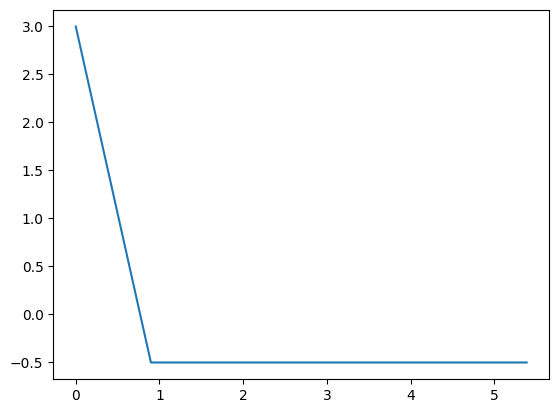

In [12]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = max(f)

    def __call__(self, inputs, **kwargs):
        return np.sum([c * np.cos(inputs * f) for f, c in zip(self.f, self.c)], axis=0)

freqs = [1,2,3]
coeffs = [1,1,1]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs,freqs)

x = np.arange(0,2 * np.pi, 2 * np.pi/fs)

out = model_fct(x)

fig, ax = plt.subplots()
ax.plot(x, out)


7


<StemContainer object of 3 artists>

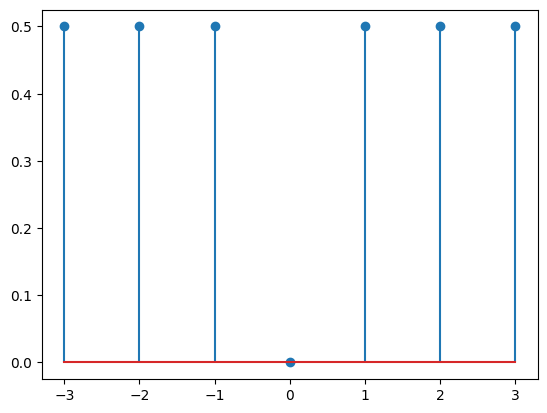

In [13]:
X = np.fft.fft(out)

X_freq = np.fft.fftfreq(X.size, 1/fs)

if X.size % 2 == 0:
    X = np.delete(X, len(X) // 2)
    X_freq = np.delete(X_freq, len(X_freq) // 2)
    
print(len(X))
X_shift = np.fft.fftshift(X)
X_freq_shift = np.fft.fftshift(X_freq)

fig, ax = plt.subplots()
ax.stem(X_freq_shift, np.abs(X_shift)/X_shift.size)

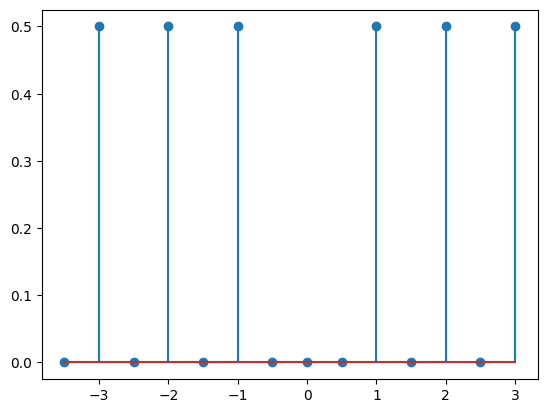

In [14]:
coeffs, freqs = Coefficients.get_spectrum(model_fct, mfs=1, mts=2, trim=False, shift=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
plt.show()

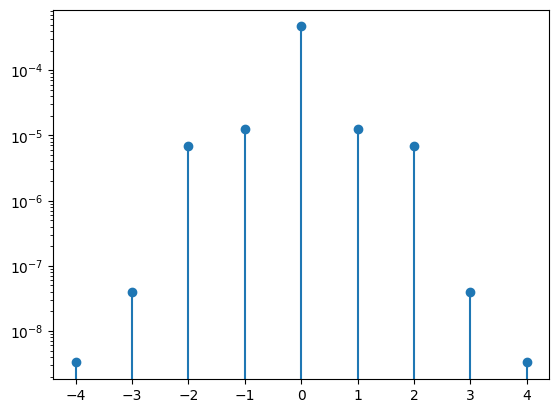

In [15]:
model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
    random_seed=1000
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1
, shift=True)

psd = Coefficients.get_psd(coeffs)

fig, ax = plt.subplots()
ax.stem(freqs, psd)
#logy
ax.set_yscale('log')
plt.show()

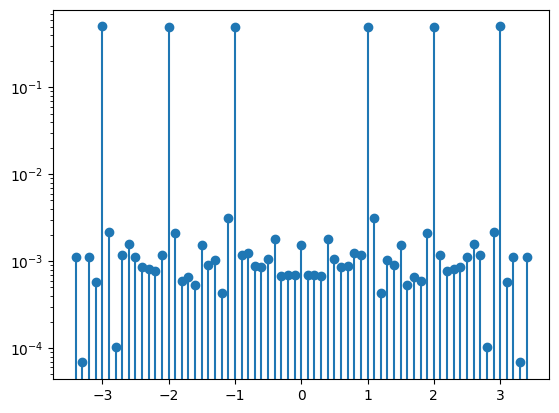

In [16]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = max(f)
        self.rng = np.random.default_rng(1000)

    def __call__(self, inputs, **kwargs):
        noise = self.rng.normal(0, 0.01, inputs.size)
        # noise = 0
        return np.sum([c * np.cos(noise + ((inputs * f))) for f, c in zip(self.f, self.c)], axis=0)

freqs = [1,2,3]
coeffs = [1,1,1]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs,freqs)

out = model_fct(x)

coeffs, freqs = Coefficients.get_spectrum(model_fct, mfs=1, mts=10, trim=True, shift=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
ax.set_yscale('log')
plt.show()